# Clustering Alanine Dipeptide using Metadynamics Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import ShapeGMM
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts
import torch

## Read trajectory

Read the trajectory.  This trajectory contains 100k frames of alanine dipeptide (ADP) run with standard metadynamics.  Details of the simulation can be found in the input file but what is most important here is that this is a biased MD simulation.  Thus each frame does contribute equally to the unbiased distribution.  

In [2]:
prmtopFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
trajFileName = "run_ala2_metad_sigma0.3_height1.2_pace500.xtc"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('name C N CA')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms in selection: 5


## Perform Cross Validation with Uniform Weights

We will start by assuming each frame has equal weight.  This is wrong but will serve as a reference.  We will use the the cross validation script contained in the shapeGMMTorch utils

We will scan from 1 to 6 components.

In [3]:
# define cluster array
component_array = np.arange(1,7,1).astype(int)
print(component_array)

[1 2 3 4 5 6]


In [4]:
# uniform weights
train, cv = cross_validate_component_scan(traj_data, component_array, covar_type="kronecker", n_training_sets=3, n_attempts = 10, dtype=torch.float64, device=torch.device("cpu"))

Number of atoms: 5
Covariance type: kronecker
Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 3
Number of attempts per set/component: 10
Component array: [1 2 3 4 5 6]
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               1               1             19.6873          14.365
              1               2               1             20.5223          30.978
              1               2               2             20.5393          35.102
              1               2               3             20.5391          34.934
              1               2               4             20.5401          35.127
              1               2               5             20.5395          35.087
              1               2               6             20.5391          34.428

## Perform Cross Validation with MetaD Weights for each Frame

We will read the metadynamics weight from the colvar file.  ***Note that there are various ways of determining a weight per frame from metadynamics simulations.  Here we will choose the exponential of $V(s,t)-c(t)$.***

In [4]:
# load the weights from c(t)/rbias column in the metaD colvars file
frame_weights = np.loadtxt("run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat",comments="#")[:,-2]
# exponential
frame_weights = np.exp(frame_weights/0.593)
# normalize
frame_weights /= np.sum(frame_weights)
print(np.sum(frame_weights))

1.0


In [ ]:
# CV scan with non-uniform weights
metaD_train, metaD_cv = cross_validate_component_scan(traj_data, component_array, frame_weights=frame_weights, covar_type="kronecker", n_training_sets=3, n_attempts = 10, dtype=torch.float64, device=torch.device("cpu"))

### Save and load log likelihood data for quick use

In [7]:
# save data (optional - don't have to do this)
np.savetxt("uniform_frame_weights_ll_train_5atoms.dat", train)
np.savetxt("uniform_frame_weights_ll_cv_5atoms.dat", cv)
np.savetxt("metaD_frame_weights_ll_train_5atoms.dat", metaD_train)
np.savetxt("metaD_frame_weights_ll_cv_5atoms.dat", metaD_cv)

In [4]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("uniform_frame_weights_ll_train_5atoms.dat")
cv = np.loadtxt("uniform_frame_weights_ll_cv_5atoms.dat")
metaD_train = np.loadtxt("metaD_frame_weights_ll_train_5atoms.dat")
metaD_cv = np.loadtxt("metaD_frame_weights_ll_cv_5atoms.dat")

## Make Log Likelihood vs number of Cluster Plots

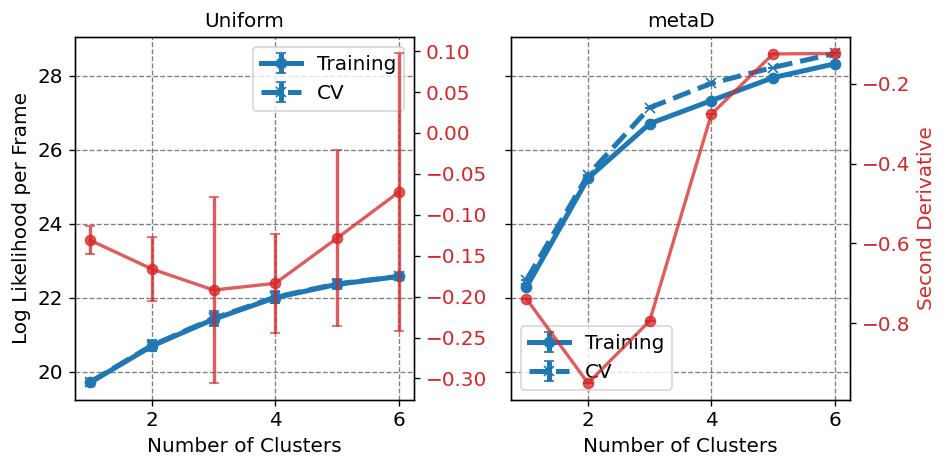

In [11]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch.utils import plot_log_likelihood_with_dd
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plot_log_likelihood_with_dd(ax[0],component_array,train.T,cv.T,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# metaD Weights
ax[1].set_title("metaD",fontsize=12)
plot_log_likelihood_with_dd(ax[1],component_array,metaD_train.T,metaD_cv.T,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True)
plt.tight_layout()
plt.show();

## Fit a $n_{clusters}=4$ object with metaD weights

In [ ]:
# fit a shapeGMM object for n=4 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_4clusters = sgmm_fit_with_attempts(traj_data[::2], 4, 10, frame_weights = frame_weights[::2], dtype=torch.float64, device=torch.device("cpu"))

## Fit a $n_{clusters}=3$ object with metaD weights

In [ ]:
# fit a shapeGMM object for n=3 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights = sgmm_fit_with_attempts(traj_data[::2], 3, 10, frame_weights = frame_weights[::2],dtype=torch.float64, device=torch.device("cpu"))

## Fit a $n_{clusters}=2$ object with metaD weights

In [ ]:
# fit a shapeGMM object for n=2 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights_2clusters = sgmm_fit_with_attempts(traj_data[::2], 2, 10, frame_weights = frame_weights[::2],dtype=torch.float64, device=torch.device("cpu"))

Number of components    : 2
Number of attempts      : 10
Covariance type         : kronecker
Data type (dtype)       : torch.float64
Device                  : cpu
Number of train frames  : 50001
Number of atoms         : 5
 Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------


## Fit a $n_{clusters}=3$ object with uniform frame weights

In [ ]:
# fit a shapeGMM object for n=4 with uniform weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_uniform_weights_3clusters = sgmm_fit_with_attempts(traj_data[::2], 3, 10, dtype=torch.float64, device=torch.device("cpu"))

## Ramachandran Plots

In [ ]:
# compute phi psi
from MDAnalysis.analysis import dihedrals
protein = coord.select_atoms("protein")
rama = dihedrals.Ramachandran(protein).run()
print(rama.results.angles.shape)

In [ ]:
# Make Ramachandran plot
def rama_plot(ax,phi,psi,c,title,fontsize=16):
    # make a grid
    ax.grid(which='major', axis='both', color='#808080', linestyle='--')
    # set ticks and axis labels
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylabel("$\psi$",fontsize=fontsize)
    ax.set_xlabel("$\phi$",fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    # scatter plot
    ax.scatter(phi, psi,c=c,s=0.4)
    # enforce range
    ax.set_ylim(-180,180)
    ax.set_xlim(-180,180)
    # equal aspect ratio
    ax.set_aspect("equal")



fontsize=16
phi = rama.results.angles[::2,0,0]
psi = rama.results.angles[::2,0,1]
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
c = sgmm_uniform_weights_3clusters.cluster_ids[::2]
rama_plot(ax[0,0],phi,psi,c,"Uniform 3 clusters")
c = sgmm_metaD_weights_2clusters.cluster_ids
rama_plot(ax[0,1],phi,psi,c,"metaD 2 clusters")
c = sgmm_metaD_weights.cluster_ids
rama_plot(ax[1,0],phi,psi,c,"metaD 3 clusters")
c = sgmm_metaD_weights_4clusters.cluster_ids
rama_plot(ax[1,1],phi,psi,c,"metaD 4 clusters")

#show plot
plt.tight_layout()
plt.show()

In [ ]:
from MDAnalysis.lib.distances import calc_dihedrals
# make fe
def plot_rama_sgmm_fe(ax,fig,phi,psi,sgmm_obj,title,fontsize=16,contour_levels= np.arange(0,30,1)):
    nbins  = 32
    range_ = [-180,180]

    phis = calc_dihedrals(sgmm_obj.centers[:,0,:],sgmm_obj.centers[:,1,:],sgmm_obj.centers[:,2,:],sgmm_obj.centers[:,3,:])
    psis = calc_dihedrals(sgmm_obj.centers[:,1,:],sgmm_obj.centers[:,2,:],sgmm_obj.centers[:,3,:],sgmm_obj.centers[:,4,:])
    H, xedges, yedges = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=sgmm_obj.frame_weights*np.exp(sgmm_obj.train_frame_log_likelihood))
    bin_weights = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=sgmm_obj.frame_weights)[0]

    H = -np.log(H) + np.log(bin_weights)
    H = H.T
    H -= np.nanmin(H)

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    xx, yy = np.meshgrid(xcenters, ycenters)

    ax.set_xlabel("$\phi$ (radians)", fontsize=fontsize)
    ax.set_ylabel("$\psi$ (radians)", fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    ax.contour(xx, yy, H, cmap="binary", levels=5, linestyles="--")
    ax.contourf(xx, yy, H, cmap='jet', levels=20)
    #ax.set_clim(0,50)
    #cbar = fig.colorbar()
    #cbar.set_label("FE/kT", fontsize=fontsize)
    ax.scatter(phis*180/np.pi, psis*180/np.pi, marker='o', s=200*sgmm_obj.weights, color="black")

def plot_rama_metaD_fe(ax,fig,phi,psi,rbias,title,fontsize=16,contour_levels= np.arange(0,30,1)):
    nbins  = 32
    range_ = [-180,180]
    kt = 0.596161
    
    H, xedges, yedges = np.histogram2d(phi, psi, bins=nbins,\
                                   range=[range_, range_], weights=np.exp(rbias/kt))

    H = -np.log(H.T)
    #H *= gamma/(gamma-1)   #! check here it is mutiplied by pre-factor!!
    H *= kt  #! check here multiplying by kt
    H -= np.nanmin(H)

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    xx, yy = np.meshgrid(xcenters, ycenters)

    ax.set_xlabel("$\phi$ (radians)", fontsize=fontsize)
    ax.set_ylabel("$\psi$ (radians)", fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    ax.contour(xx, yy, H, cmap="binary", levels=5, linestyles="--")
    ax.contourf(xx, yy, H, cmap='jet', levels=20)
    #plt.clim(0,50)
    #cbar = fig.colorbar()
    #cbar.set_label("FE/kT", fontsize=fontsize)

    
phi = rama.results.angles[:,0,0]
psi = rama.results.angles[:,0,1]

fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=80)
contour_levels = np.arange(0,25,2)
# metaD FE
rbias = np.loadtxt("run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat",comments="#")[:,-2]
plot_rama_metaD_fe(ax[0,0],fig,phi,psi,rbias,"metaD FE",contour_levels=contour_levels)
# 2 clusters
plot_rama_sgmm_fe(ax[0,1],fig,phi[::2],psi[::2],sgmm_metaD_weights_2clusters,"SGMM 2 Clusters")
# 3 clusters
plot_rama_sgmm_fe(ax[1,0],fig,phi[::2],psi[::2],sgmm_metaD_weights,"SGMM 3 Clusters")
# 4 clusters
plot_rama_sgmm_fe(ax[1,1],fig,phi[::2],psi[::2],sgmm_metaD_weights_4clusters,"SGMM 4 Clusters")

#show plot
plt.tight_layout()
plt.show()